Por favor, sube tu archivo spam.csv:


Saving spa.csv to spa (1).csv

Columnas detectadas en el archivo: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Distribución de clases:
spam
0    0.865937
1    0.134063
Name: proportion, dtype: float64


<ipython-input-2-3ce064ae7b62>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['spam'], palette='pastel')


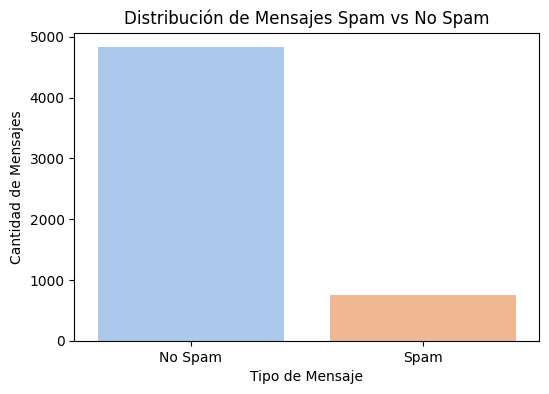


Probabilidad previa de spam: 13.41%
Probabilidad previa de no spam: 86.59%

=== Naive Bayes Manual ===
Exactitud (Accuracy): 99.82%
Precisión (Precision): 100.00%
Sensibilidad (Recall): 98.66%
Puntuación F1: 99.32%

=== Scikit-learn MultinomialNB ===
Exactitud (Accuracy): 97.40%
Precisión (Precision): 100.00%
Sensibilidad (Recall): 80.54%
Puntuación F1: 89.22%


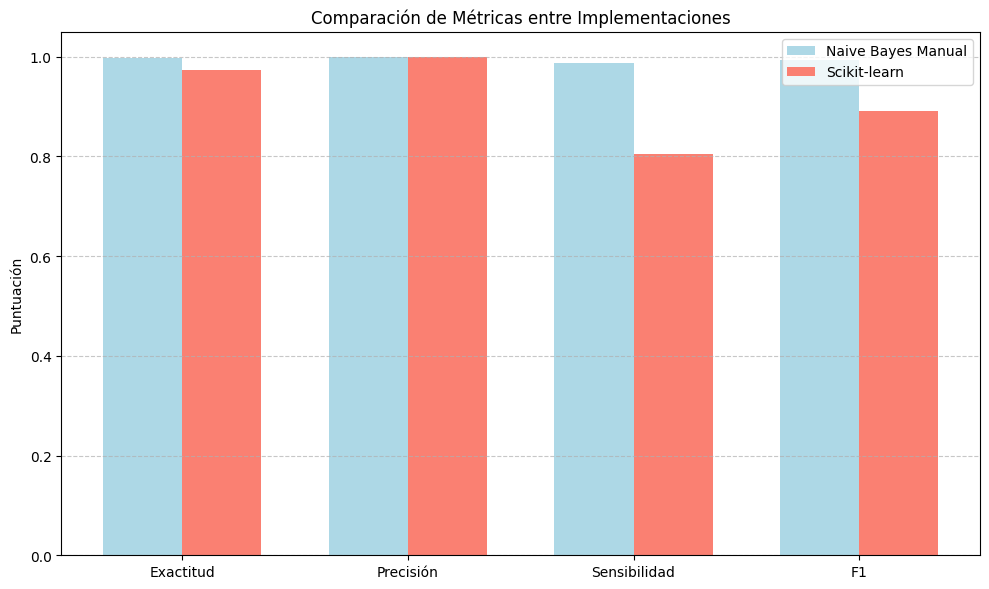

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import chardet

# ========== CARGAR Y PREPROCESAR DATOS ==========
print("Por favor, sube tu archivo spam.csv:")
from google.colab import files
uploaded = files.upload()
nombre_csv = next(iter(uploaded.keys()))

# Detección de codificación del archivo
try:
    with open(nombre_csv, 'rb') as f:
        rawdata = f.read(100000)  # Lee los primeros 100KB para detectar codificación
        encoding = chardet.detect(rawdata)['encoding']

    # Intentar leer con la codificación detectada
    try:
        data = pd.read_csv(nombre_csv, encoding=encoding)
    except UnicodeDecodeError:
        # Si falla, probar con codificaciones alternativas
        for enc in ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']:
            try:
                data = pd.read_csv(nombre_csv, encoding=enc)
                encoding = enc
                print(f"Usando codificación alternativa: {enc}")
                break
            except:
                continue
        else:
            raise ValueError("No se pudo determinar la codificación del archivo")

except Exception as e:
    print(f"Error al leer el archivo: {str(e)}")
    raise

# Verificar estructura del DataFrame
print("\nColumnas detectadas en el archivo:", data.columns.tolist())

# Seleccionar y renombrar columnas
if len(data.columns) >= 2:
    data = data.iloc[:, :2]  # Tomar las dos primeras columnas
    data.columns = ['etiqueta', 'texto']  # Renombrar
else:
    raise ValueError("El archivo debe contener al menos 2 columnas (texto y etiqueta)")

# Limpieza y conversión de etiquetas
data['etiqueta'] = data['etiqueta'].astype(str).str.strip().str.lower()
data['spam'] = data['etiqueta'].apply(lambda x: 1 if x == 'spam' else 0)

# Eliminar filas con valores nulos
data = data.dropna()

# Verificar distribución de clases
if data['spam'].nunique() < 2:
    raise ValueError("El dataset debe contener ambas clases (spam y no spam)")

print("\nDistribución de clases:")
print(data['spam'].value_counts(normalize=True))

# ========== VISUALIZACIÓN DE DATOS ==========
plt.figure(figsize=(6, 4))
sns.countplot(x=data['spam'], palette='pastel')
plt.xticks([0, 1], ['No Spam', 'Spam'])
plt.xlabel("Tipo de Mensaje")
plt.ylabel("Cantidad de Mensajes")
plt.title("Distribución de Mensajes Spam vs No Spam")
plt.show()

# ========== PREPARACIÓN DE CARACTERÍSTICAS ==========
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
features = vectorizer.fit_transform(data["texto"])
features_array = features.toarray()

# Calcular probabilidades previas
P_spam = data["spam"].sum() / len(data)
P_ham = 1 - P_spam
print(f"\nProbabilidad previa de spam: {P_spam:.2%}")
print(f"Probabilidad previa de no spam: {P_ham:.2%}")

# Calcular probabilidades condicionales
P_caracteristicas_spam = features_array[data["spam"] == 1].sum(axis=0) / features_array[data["spam"] == 1].sum()
P_caracteristicas_ham = features_array[data["spam"] == 0].sum(axis=0) / features_array[data["spam"] == 0].sum()

# Evitar problemas numéricos
P_caracteristicas_spam = np.clip(P_caracteristicas_spam, 1e-10, 1)
P_caracteristicas_ham = np.clip(P_caracteristicas_ham, 1e-10, 1)

# ========== DIVISIÓN DE DATOS ==========
X_train, X_test, y_train, y_test = train_test_split(
    features_array,
    data["spam"],
    test_size=0.2,
    random_state=42,
    stratify=data["spam"]  # Mantener proporción de clases
)

# ========== IMPLEMENTACIÓN MANUAL DE NAIVE BAYES ==========
def predecir_naive_bayes(X):
    """Calcula la probabilidad posterior usando log-probabilidades"""
    log_prob_spam = np.log(P_spam) + np.sum(np.log(P_caracteristicas_spam) * X, axis=1)
    log_prob_ham = np.log(P_ham) + np.sum(np.log(P_caracteristicas_ham) * X, axis=1)
    return (log_prob_spam > log_prob_ham).astype(int)

y_pred = predecir_naive_bayes(X_test)

# ========== EVALUACIÓN DEL MODELO ==========
def imprimir_metricas(y_real, y_pred, titulo="Resultados"):
    print(f"\n=== {titulo} ===")
    print(f"Exactitud (Accuracy): {accuracy_score(y_real, y_pred):.2%}")
    print(f"Precisión (Precision): {precision_score(y_real, y_pred):.2%}")
    print(f"Sensibilidad (Recall): {recall_score(y_real, y_pred):.2%}")
    print(f"Puntuación F1: {f1_score(y_real, y_pred):.2%}")

imprimir_metricas(y_test, y_pred, "Naive Bayes Manual")

# ========== COMPARACIÓN CON SCIKIT-LEARN ==========
modelo_nb = MultinomialNB()
modelo_nb.fit(X_train, y_train)
y_pred_sk = modelo_nb.predict(X_test)

imprimir_metricas(y_test, y_pred_sk, "Scikit-learn MultinomialNB")

# ========== VISUALIZACIÓN COMPARATIVA ==========
metricas = {
    'Exactitud': accuracy_score(y_test, y_pred),
    'Precisión': precision_score(y_test, y_pred),
    'Sensibilidad': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred)
}

sk_metricas = {
    'Exactitud': accuracy_score(y_test, y_pred_sk),
    'Precisión': precision_score(y_test, y_pred_sk),
    'Sensibilidad': recall_score(y_test, y_pred_sk),
    'F1': f1_score(y_test, y_pred_sk)
}

plt.figure(figsize=(10, 6))
x = np.arange(len(metricas))
ancho = 0.35

plt.bar(x - ancho/2, metricas.values(), ancho, label='Naive Bayes Manual', color='lightblue')
plt.bar(x + ancho/2, sk_metricas.values(), ancho, label='Scikit-learn', color='salmon')

plt.xticks(x, metricas.keys())
plt.ylabel("Puntuación")
plt.title("Comparación de Métricas entre Implementaciones")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()